# Lecture 9: Transfer learning


We provide a colab with training, inference, and clustering code using transfer learning models

## Notebook steps:
1. Load and preprocess the dataset
2. Define the Transformer model
3. Train the model
4. Evaluate the model


In [1]:
!pip install datasets[audio]==3
!pip install matplotlib
!pip install torch
!pip install torchcodec
!pip install tqdm
!pip install transformers
!pip install scikit-learn
!pip install omar_rq

In [2]:
import math
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from torchaudio.transforms import MelSpectrogram, Resample
from tqdm.auto import tqdm, trange
from omar_rq import get_model

device = "cuda"  # Configure depending on the runtime

In [3]:
# Use Datasets to load GTZAN
ds = load_dataset("sanchit-gandhi/gtzan", split="train")

# make random train/val splits
splits = ds.train_test_split(test_size=0.3, seed=42)
train_ds = splits["train"]
val_test_ds = splits["test"]

splits = val_test_ds.train_test_split(test_size=0.5, seed=42)
val_ds = splits["train"]
test_ds = splits["test"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
class GTZANAudioDataset(Dataset):
    """Audio GTZAN Genre dataset based on HuggingFace Datasets
    """

    def __init__(self, dataset, device):
        self.orig_sample_rate = 32000
        self.sample_rate = 24000
        self.audio_duration = 3  # Segment durations
        self.device =  device

        self.dataset = dataset
        self.n_samples = self.sample_rate * self.audio_duration
        self.resample = Resample(orig_freq=self.orig_sample_rate, new_freq=self.sample_rate)

        # Load audio and labels
        self.audio = {}
        self.natural_labels = {}
        for track in tqdm(self.dataset, desc="Loading audio"):
            tid = Path(track["file"]).stem
            genre = tid.split(".")[0]

            x = track["audio"]["array"]
            x = torch.tensor(x)
            sr = track["audio"]["sampling_rate"]

            if sr != self.sample_rate:
              if sr != self.orig_sample_rate:
                self.resample = Resample(orig_freq=sr, new_freq=self.sample_rate)
                self.orig_sample_rate = sr

              x = self.resample(x.float())

            self.audio[tid] = x.to(self.device)
            self.natural_labels[tid] = genre

        self.tids = list(self.audio.keys())

        # One hot encode labels
        natural_labels = np.array(list(self.natural_labels.values())).reshape(-1, 1)
        ohe = OneHotEncoder()
        one_hot_labels = ohe.fit_transform(natural_labels).toarray()
        self.labels = {k: v for k, v in zip(self.tids, one_hot_labels)}

    def __len__(self):
        return len(self.tids)

    def get_start_end_indices(self, min, max):
        start = random.randint(min, max - self.n_samples)
        end = start + self.n_samples
        return start, end

    def __getitem__(self, idx):
        tid = self.tids[idx]
        audio_full = self.audio[tid]
        labels = self.labels[tid]
        natural_labels = self.natural_labels[tid]

        # get the segment from a random position in the track.
        min_pos, max_pos = 0, audio_full.shape[0]

        start, end = self.get_start_end_indices(min_pos, max_pos)
        audio = audio_full[start:end]

        return {"audio": audio, "labels": labels, "natural_labels": natural_labels}


class GTZANOMARRQDataset(Dataset):
    """OMAR-RQ embedding dataset based on GTZAN audio.
    """

    def __init__(self, audio_dataset, device):
        self.device =  device
        self.audio_dataset = audio_dataset

        self.labels = self.audio_dataset.labels
        self.natural_labels = self.audio_dataset.natural_labels
        self.tids = self.audio_dataset.tids

        # Instanciate OMAR-RQ model
        self.model = get_model(model_id="mtg-upf/clap_omarrq_mp_small_music", device=self.device)
        self.model.eval()

        # Select intermediate layer
        self.layers = [6]

        # Load audio and labels
        self.embeddings = {}
        for id, audio in tqdm(self.audio_dataset.audio.items(), desc="Computing embeddings"):

            audio = torch.tensor(audio).unsqueeze(0)
            audio = audio.float()
            audio.to(self.device)

            with torch.no_grad():
              embeddings = self.model.extract_embeddings(audio, layers=self.layers)

            embeddings = torch.mean(embeddings, dim=2)
            embeddings = embeddings.squeeze()

            self.embeddings[id] = embeddings

    def __len__(self):
        return len(self.tids)


    def __getitem__(self, idx):
        tid = self.tids[idx]
        embeddings = self.embeddings[tid]
        labels = self.labels[tid]
        natural_labels = self.natural_labels[tid]

        return {"embeddings": embeddings, "labels": labels, "natural_labels": natural_labels}

# Audio datasets
train_audio_dataset = GTZANAudioDataset(train_ds, device=device)
val_audio_dataset = GTZANAudioDataset(val_ds, device=device)
test_audio_dataset = GTZANAudioDataset(test_ds, device=device)

# Embedding datasets
train_dataset = GTZANOMARRQDataset(train_audio_dataset, device=device)
val_dataset = GTZANOMARRQDataset(val_audio_dataset, device=device)
test_dataset = GTZANOMARRQDataset(test_audio_dataset, device=device)

batch_size = 32

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

OMAR-RQ: 396 weights loaded for `net`
OMAR-RQ: 2 weights loaded for `embedding_layer`


Computing embeddings:   0%|          | 0/699 [00:00<?, ?it/s]

/tmp/ipython-input-3368046715.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio = torch.tensor(audio).unsqueeze(0)


OMAR-RQ: 396 weights loaded for `net`
OMAR-RQ: 2 weights loaded for `embedding_layer`


Computing embeddings:   0%|          | 0/150 [00:00<?, ?it/s]

OMAR-RQ: 396 weights loaded for `net`
OMAR-RQ: 2 weights loaded for `embedding_layer`


Computing embeddings:   0%|          | 0/150 [00:00<?, ?it/s]

In [7]:
class FeatureExtractor(nn.Module):
    """Log mel-spectrogram feature extractor.
    """

    def __init__(self, **kwargs):
        super().__init__()
        self.melspectrogram = MelSpectrogram(**kwargs)

    def forward(self, x):
        x = self.melspectrogram(x)

        # Log-compression
        x = torch.log10(1 + 1000 * x)
        return x

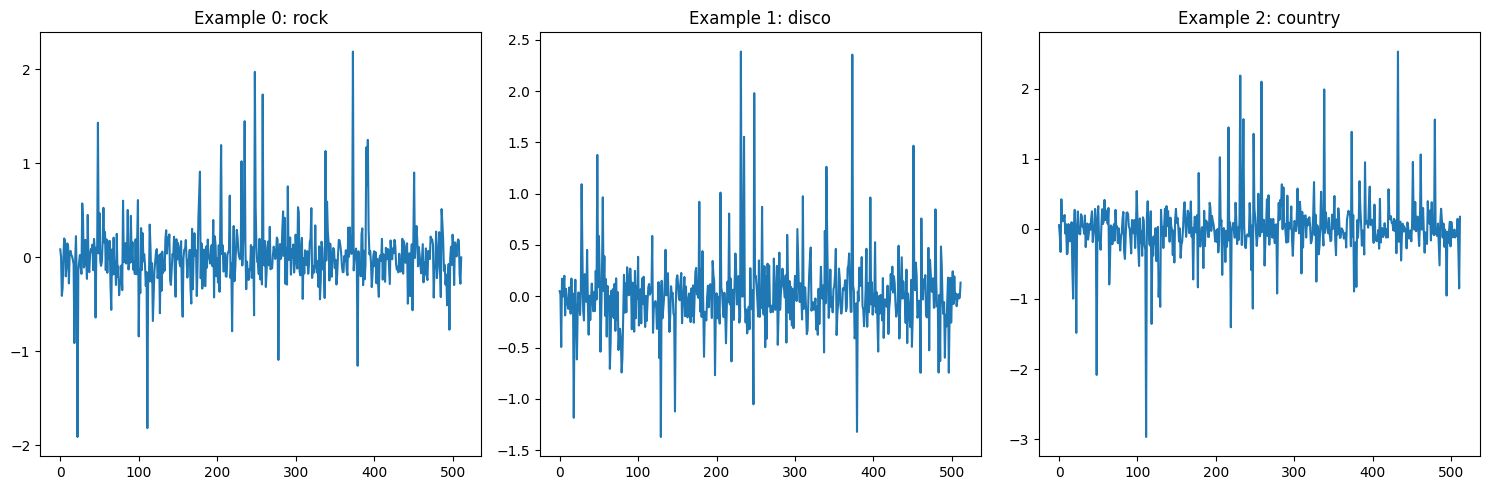

In [8]:
# Fetch a batch of data
batch = next(iter(val_loader))
embeddings = batch["embeddings"].cpu().numpy()

# Visualize the first three mel-spectrograms in the batch
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].plot(embeddings[i])
    axes[i].set_title(f"Example {i}: {batch['natural_labels'][i]}")

plt.tight_layout()
plt.show()

In [9]:
n_classes = len(set(val_dataset.natural_labels.values()))

print("Embeddings shape:", embeddings.shape)
print("Number of classes:", n_classes)

Embeddings shape: (32, 512)
Number of classes: 10


In [10]:
class Transformer(nn.Module):
    """Transformer model for audio classification.

    Args:
        kernel (tuple, optional): Kernel size for the convolutional patch embedding. Defaults to (8, 8).
        stride (tuple, optional): Stride for the convolutional patch embedding. Defaults to (8, 8).
        n_blocks (int, optional): Number of Transformer encoder blocks. Defaults to 2.
        emb_dim (int, optional): Embedding dimension. Defaults to 128.
        n_heads (int, optional): Number of attention heads. Defaults to 2.
        mlp_ratio (int, optional): Ratio of MLP hidden dimension to embedding dimension. Defaults to 2.
        output_size (int, optional): Number of output classes. Defaults to 10.
    """

    def __init__(
        self,
        kernel: tuple = (8, 8),
        stride: tuple = (8, 8),
        n_blocks: int = 2,
        emb_dim: int = 128,
        n_heads: int = 2,
        mlp_ratio: int = 2,
        output_size: int = 10,
        pos_enc_gain: float = 0.0,
        cls_token_ratio: float = 0.0,
    ):
        super().__init__()

        self.n_blocks = n_blocks
        self.emb_dim = emb_dim
        self.n_heads = n_heads
        self.mlp_ratio = mlp_ratio
        self.output_size = output_size
        self.pos_enc_gain = pos_enc_gain
        self.cls_token_ratio = cls_token_ratio

        self.norm = nn.BatchNorm2d(1)

        padding = kernel[0] // 2
        self.patching = nn.Conv2d(
            1, self.emb_dim, kernel_size=kernel, stride=stride, padding=padding
        )

        self.blocks = nn.ModuleList([
          nn.TransformerEncoderLayer(
              self.emb_dim,
              self.n_heads,
              dim_feedforward=self.emb_dim * self.mlp_ratio,
              dropout=0.1,
              norm_first=True,
          ) for _ in range(self.n_blocks)])

        self.cls = nn.Parameter(torch.randn(1, 1, self.emb_dim))

        nn.init.normal_(self.cls, std=0.02)

        self.fc1 = nn.Linear(self.emb_dim, self.emb_dim)
        self.fc2 = nn.Linear(self.emb_dim, self.output_size)

    def positional_encoding(self, seq_len):
        position = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, self.emb_dim, 2, dtype=torch.float32) * -(math.log(10000.0) / self.emb_dim))

        pe = torch.zeros(seq_len, self.emb_dim, device=self.cls.device)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x):
        # Add embedding dimension
        x = x.unsqueeze(1)

        # Normalize input to zero-mean unit std.
        x = self.norm(x)

        # Divide the signal into patches
        x = self.patching(x)  # [B, 1, freq, time] -> [b, E, M, T]

        B, E, M, T = x.shape

        # Generate positional encodings for frequency and time
        pe_m = self.positional_encoding(M) # (M, E)
        pe_t = self.positional_encoding(T) # (T, E)

        pe_m_reshaped = pe_m.transpose(0, 1).unsqueeze(0).unsqueeze(3) # (1, E, F, 1)
        pe_t_reshaped = pe_t.transpose(0, 1).unsqueeze(0).unsqueeze(2) # (1, E, 1, T)

        # Add positional encoding with small gain.
        x = x + self.pos_enc_gain * (pe_m_reshaped + pe_t_reshaped)

        x = x.flatten(start_dim=2)  # [B, E, F, T] -> [B, E, F * T]
        x = x.swapaxes(1, 2)  # [B, E, F * T] -> [B, F * T, E]

        # Concatenate CLS token
        cls = self.cls.repeat(B, 1, 1)
        x = torch.cat([cls, x], dim=1)

        # Transformer backbone
        for block in self.blocks:
          x = block(x)

        # Classification on top of the CLS + average of the rest of tokens
        x_cls = x[:, 0, :]
        x_mean = x[:, 1:, :].mean(dim=1)
        x = self.cls_token_ratio * x_cls + (1 - self.cls_token_ratio) * x_mean

        # Dense classification head
        x = F.layer_norm(x, (self.emb_dim,))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [11]:
class MLP(nn.Module):
    def __init__(
        self,
        input_size: int=512,
        dense_size: int=64,
        output_size: int=10,
    ):
        super().__init__()
        self.input_size = input_size
        self.dense_size = dense_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, self.dense_size)
        self.fc2 = nn.Linear(self.dense_size, self.output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Step 3: Train the models
Set up the training loop with loss functions and optimizers.


In [12]:
def step(batch, loss_fn, model, optimizer=None, mode="audio"):
    y = batch["labels"].to(device)

    if mode == "audio":
        x = batch["audio"].to(device)
        x = feature_extractor(x)
    elif mode == "embeddings":
        x = batch["embeddings"]

    # Forward
    y_est = model(x)

    # Compute loss
    loss = loss_fn(y_est, y)
    step_loss = loss.item()

    # Compute metrics
    y_est = y_est.softmax(dim=1)
    y_int = torch.argmax(y, dim=1).cpu().numpy()
    y_est_int = torch.argmax(y_est, dim=1).cpu().numpy()

    step_acc = accuracy_score(y_int, y_est_int)

    # Backprop
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return step_loss, step_acc

def train(
    model,
    train_dataset,
    val_dataset,
    n_epochs=3,
    lr=0.001,
    device="cuda",
    batch_size=32,
    mode="audio",
):
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    pbar = trange(n_epochs, desc="Training", total=n_epochs)
    for epoch in range(n_epochs):
        # Training loop

        model.train()
        total_loss, total_acc = 0, 0

        for batch in train_loader:
            step_loss, step_acc = step(batch, loss_fn, model, optimizer, mode=mode)
            total_loss += step_loss
            total_acc += step_acc

        train_loss = total_loss / len(train_loader)
        train_acc = total_acc / len(train_loader)

        # Validation loop
        model.eval()
        total_loss, total_acc = 0, 0

        for batch in val_loader:
            step_loss, step_acc = step(batch, loss_fn, model, mode=mode)
            total_loss += step_loss
            total_acc += step_acc

        val_loss = total_loss / len(val_loader)
        val_acc = total_acc / len(val_loader)

        pbar.set_postfix({
            # "epoch": f"{epoch+1}",
            "train loss": f"{train_loss:.3f}",
            "train acc": f"{train_acc:.3f}",
            "val loss": f"{val_loss:.3f}",
            "val acc": f"{val_acc:.3f}",
        })
        pbar.update(1)


def test(model, dataset, device="cuda", batch_size=32, mode="audio"):
    # Test loop
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss_fn = torch.nn.CrossEntropyLoss()

    model.eval()
    total_loss, total_acc = 0, 0

    for batch in test_loader:
        step_loss, step_acc = step(batch, loss_fn, model, mode=mode)
        total_loss += step_loss
        total_acc += step_acc

    test_loss = total_loss / len(test_loader)
    test_acc = total_acc / len(test_loader)

    print(
        f"test loss: {test_loss:.3f}, "
        + f"test acc: {test_acc:.3f}"
    )

In [13]:
feature_extractor = FeatureExtractor(n_mels=64, n_fft=1024).to(device)

model = Transformer(
    n_blocks=2,
    emb_dim=64,
    n_heads=4,
).to(device)

print("Training Transformer encoder")

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")


train(model, train_audio_dataset, val_audio_dataset, n_epochs=100, device=device, batch_size=32, mode="audio")

print("\n")
test(model, test_audio_dataset, mode="audio")

Training Transformer encoder
Number of trainable parameters: 75980


Training:   0%|          | 0/100 [00:00<?, ?it/s]



test loss: 0.872, test acc: 0.680


In [14]:
model = MLP().to(device)

print("\nTraining CNN encoder")

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"MLP Trainable parameters: {num_params}")

train(model, train_dataset, val_dataset, n_epochs=100, device=device, batch_size=32, mode="embeddings")
test(model, test_dataset, mode="embeddings")


Training CNN encoder
MLP Trainable parameters: 33482


Training:   0%|          | 0/100 [00:00<?, ?it/s]

test loss: 0.257, test acc: 0.941
